In [28]:
import pandas as pd
import numpy as np
import os
from math import log, exp
import seaborn as sns
from tqdm import tqdm, tqdm_pandas

In [29]:
def compute_repeat_sales_index():
    
    a=%system Rscript repeat_sales.R
    
    data = pd.read_csv('.rsi_index_per_bed.csv')

    data = data.rename(columns={'Unnamed: 0':'Time'})

    data = data.bfill()

    data = data.replace('NONE', np.nan).dropna(axis=1)
    
    data.to_csv('rsi_index_per_bed.csv')
    
    data = data.iloc[1:]
    
    return data

In [30]:
def compute_repeat_rents_index():
    
    a=%system Rscript repeat_rents.R
    
    data = pd.read_csv('.rri_index_per_bed_2011_to_2019.csv')

    data = data.rename(columns={'Unnamed: 0':'Time'})

    data = data.bfill()

    data = data.replace('NONE', np.nan).dropna(axis=1)
    
    data.to_csv('rsi_index_per_bed.csv')
    
    data = data.iloc[1:]
    
    return data

In [31]:
def infer_past_prices(serie):
    y, b, p = serie[['year', 'beds', 'price']]
    return (log(p) - rri[str(b)].loc[y:].cumsum()).apply(exp)

In [32]:
def compute_agg_rental_prices():
    rent_data_agg = pd.read_excel('voa-average-rent-borough.xls', sheet_name='Raw data', \
                              skiprows=2, \
                              usecols=['Year', 'Area', 'Category', 'Count of rents', 'Average'])

    rent_data_agg.head()

    # We filter the data by target region. As the data is not postcode-precise, 
    # the most accurate region would be NW (nortwest)
    rent_data_agg = rent_data_agg[rent_data_agg['Area'] == 'NORTH WEST'].drop('Area', 1)

    rent_data_agg['Category'].unique()

    # We filter by properties having a specific number of rooms
    rent_data_agg = rent_data_agg[~rent_data_agg['Category'].isin(['Room', 'All categories'])]


    beds_dict = {
        'Studio':0,
        'One Bedroom':1,
        'Two Bedroom':2,
        'Three Bedroom':3,
        'Four or more Bedrooms':4,
    }

    rent_data_agg['beds'] = rent_data_agg['Category'].apply(lambda x: beds_dict[x])

    rent_data_agg[['Count of rents', 'Average']] = rent_data_agg[['Count of rents', 'Average']].astype(int)

    rent_data_agg = rent_data_agg.groupby(['Year', 'beds'])['Count of rents', 'Average'].mean().reset_index()

    rent_data_agg.to_csv('rent_data_agg.csv')
    
    return rent_data_agg

In [33]:
rsi = compute_repeat_sales_index()
rri = compute_repeat_rents_index()
rri.index = range(2012, 2020, 1)
rsi.index = range(1996, 2020, 1)
rri = rri.sort_index(ascending=False)

In [34]:
data = pd.read_csv('nw6_data_rent.csv', index_col = 0)
data_sales = pd.read_csv('nw6_data_sale.csv', index_col = 0)
data_sales = data_sales[data_sales['beds']>0]
data = data[data['beds']<5]
data_sales = data_sales[data_sales['beds']<5]

In [35]:
inf_prices = data.apply(infer_past_prices, axis=1)

inf_prices = inf_prices.join(data)

inf_prices = inf_prices.dropna()

In [36]:
data = inf_prices.melt(id_vars=data.columns[0:8].tolist(),\
              value_vars=range(2012, 2020)).rename(columns=\
                                                   {'price':'real_price',
                                                    'year':'real_year',
                                                    'variable':'year',
                                                    'value':'price'})

In [37]:
data.to_csv('nw6_data_rent_prev_years_prediction.csv')

In [38]:
def infer_future_prices(serie):
    y, b, p = serie[['year', 'beds', 'price']]
    b = str(b)
    y = max(1996, y)
    return (rsi.loc[y:2018,b] - rsi.loc[y,b] + log(p)).apply(exp)

In [39]:
inf_prices_sales = data_sales.apply(infer_future_prices, axis=1)

In [40]:
inf_prices_sales = data_sales.join(inf_prices_sales)

In [41]:
inf_prices_sales= inf_prices_sales.melt(id_vars=data_sales.columns[0:7].tolist(), value_vars=range(2012, 2019)).rename(columns=\
                                                   {'price':'real_price',
                                                    'year':'real_year',
                                                    'variable':'year',
                                                    'value':'price'})

In [42]:
data.to_csv('nw6_data_price_fut_years_prediction.csv')

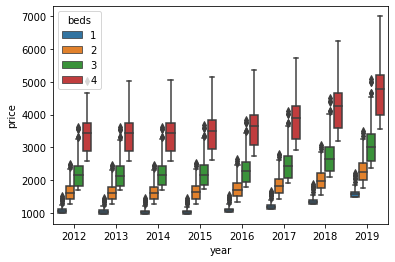

In [43]:
sns.boxplot(data=data, x='year', y='price', hue='beds')

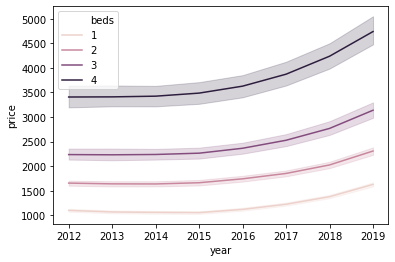

In [44]:
sns.lineplot(data=data, x='year', y='price', hue='beds')

In [45]:
rent_data_agg = compute_agg_rental_prices()
rent_data_agg = rent_data_agg[rent_data_agg['beds']>0]

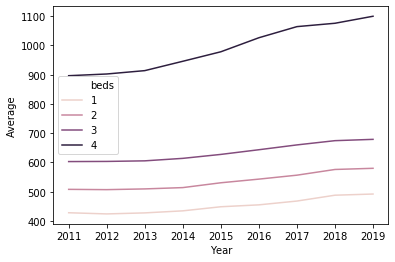

In [46]:
sns.lineplot(data=rent_data_agg, x='Year', y='Average', hue='beds')

Althought the trends are quite similar the absolute values are not. See email about this. In any case, the trends seem to make sense so they can be used.